<a href="https://colab.research.google.com/github/lim-jr/ESAA/blob/main/%EB%B0%A9%ED%95%99%ED%94%8C%EC%A0%9D1_%EB%AA%A8%EB%8D%B8%EC%B7%A8%ED%95%A9%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **유전체 정보 품종 분류 AI 경진대회**
###**배경**
유전체 염기서열에서 획득한 유전체 변이 정보인 Single Nucleotide Polymorphism 정보는 특정 개체 및 특정 품종에 따라 다른 변이 양상을 나타낼 수 있기 때문에 동일개체를 확인하거나,동일 품종을 구분하는데 활용이 가능합니다. 따라서 이번 경진대회에서는 개체 정보와 SNP 정보를 이용하여 A, B, C 품종을 분류하는 최고의 품종구분 정확도를 획득하는 것이 목표입니다.
농축수산 현장에서는 유전체 변이정보를 이용해서 품종을 구분하는 연구를 통해 품종의 다양성 혹은 품종 부정유통을 방지하기 위해 많이 활용하게 됩니다.


###**주제**
개체와 SNP 정보를 이용하여 품종 분류 AI 모델 개발



###**설명**
시장에서 세 품종이 동시에 유통될 때, 각 품종의 고유한 생산품목(우유 및 식육)의 가치 및 가격 산정에 부정유통이 차단되기 위해 현장에서 사용 할 수 있는 AI 모델이 필요합니다.

즉, 많은 SNP 정보를 통해 분류하는 것보다, 보다 더 적은 SNP 정보로 높은 분류 성능을 내는 것이 중요합니다.

따라서 이번 경진대회에서는 개체 정보와 사전에 구성된 15개의 SNP 정보를 바탕으로 품종 분류 모델을 개발해야 합니다.



##**1. 데이터 불러오기**

In [ ]:
import pandas as pd
import random
import os
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

In [ ]:
class CFG:
    SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train = pd.read_csv("/content/drive/MyDrive/ESAA/dacon/open/train.csv")
#test = pd.read_csv("/content/drive/MyDrive/ESAA/dacon/open/test.csv")
#snp_info = pd.read_csv("/content/drive/MyDrive/ESAA/dacon/open/snp_info.csv")
train = pd.read_csv("/content/drive/MyDrive/ESAA/방학/DATA/train.csv")
test = pd.read_csv('/content/drive/MyDrive/ESAA/방학/DATA/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/ESAA/방학/DATA/sample_submission.csv')

In [ ]:
train.head() #data에 null 없음 #father, mother, gender는 다 0

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C


In [ ]:
test.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,TEST_000,0,0,0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,TEST_001,0,0,0,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,TEST_002,0,0,0,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,TEST_003,0,0,0,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,TEST_004,0,0,0,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G


In [ ]:
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

In [ ]:
train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

## **2. EDA**

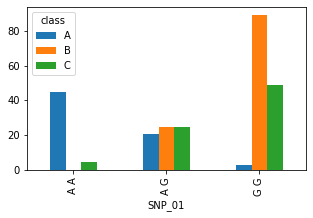

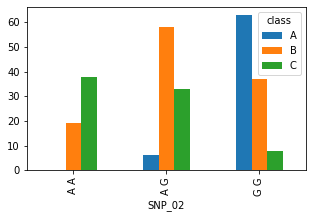

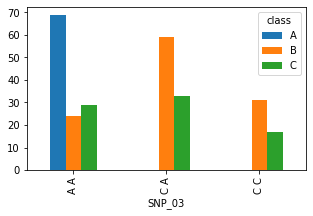

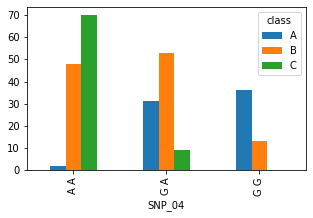

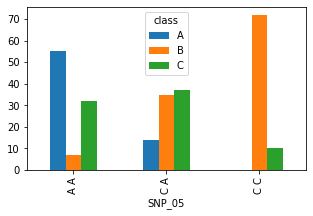

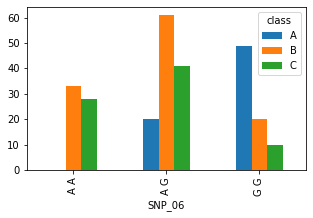

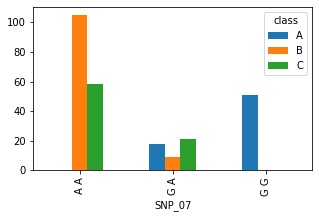

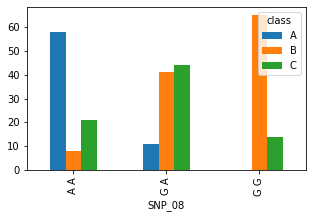

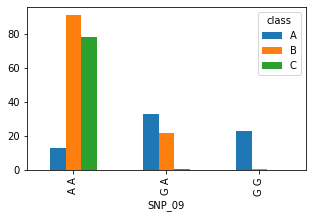

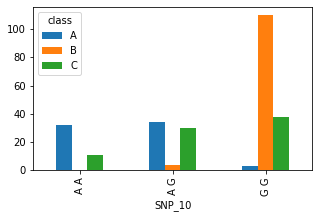

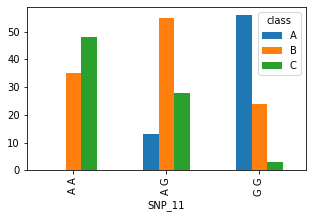

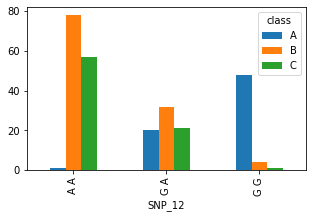

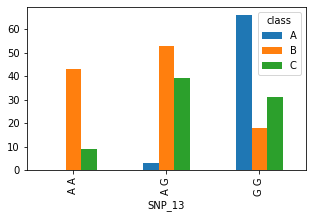

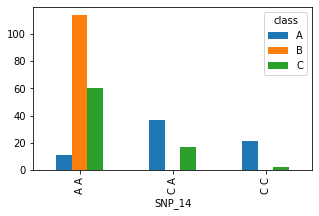

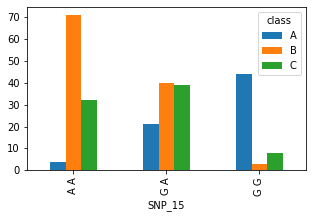

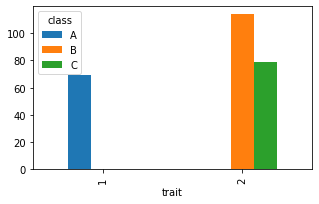

In [ ]:
for g in train.columns[train.columns.str.contains('SNP')].tolist()+['trait']:
    train.groupby(g)['class'].value_counts().unstack().plot.bar(figsize=(5,3));

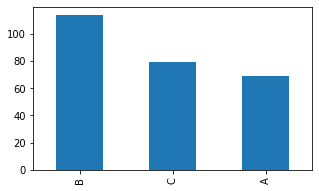

In [ ]:
train['class'].value_counts().plot.bar(figsize=(5,3))

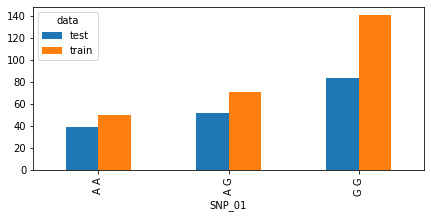

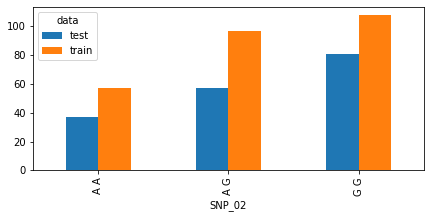

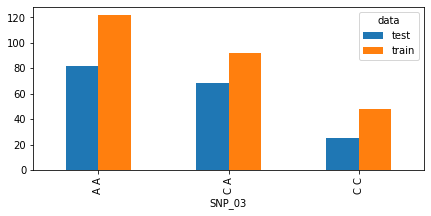

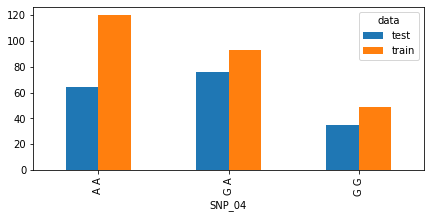

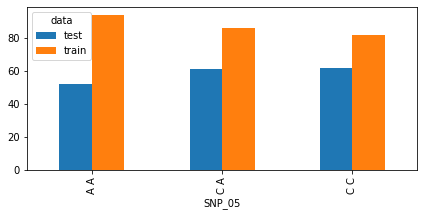

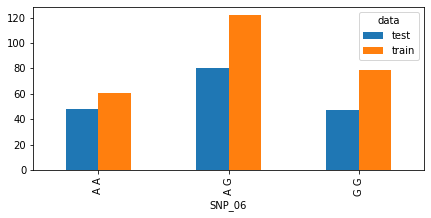

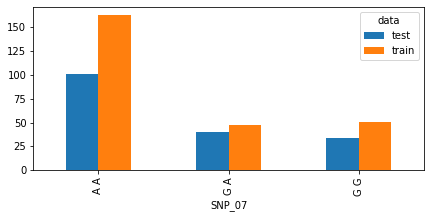

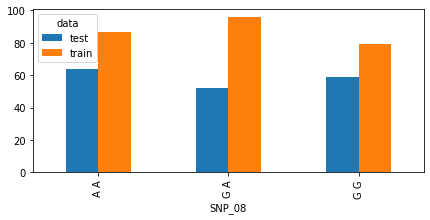

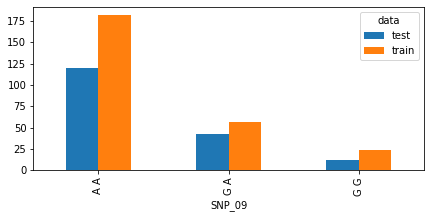

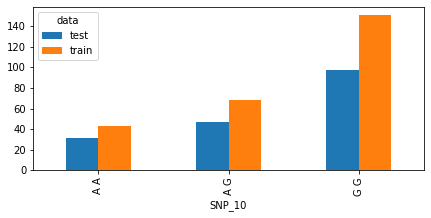

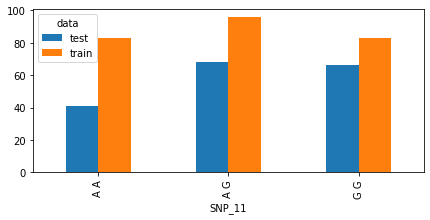

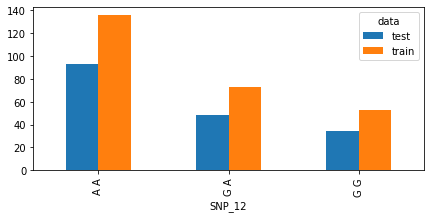

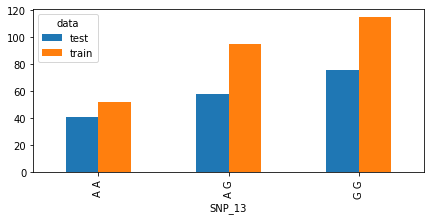

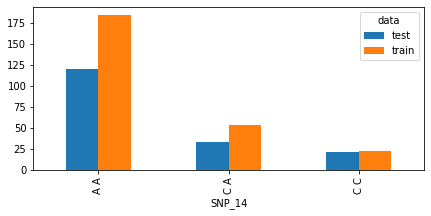

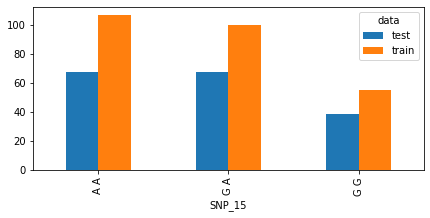

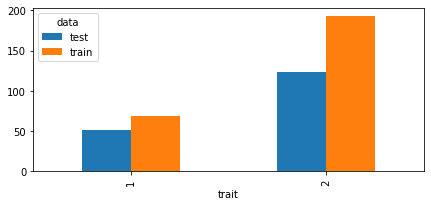

In [ ]:
#train test 비교
train['data'] = 'train'
test['data'] = 'test'
tmp = pd.concat([train,test]).reset_index(drop=True)
for g in tmp.columns[tmp.columns.str.contains('SNP')].tolist()+['trait']:   
    tmp.groupby([g])['data'].value_counts().unstack().plot.bar(figsize=(7,3));

## **3. 데이터 전처리**

### **Label-Encoding**

In [ ]:
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)] #zfill(2): 길이가 2가 되도록 숫자 앞에 0을 붙임

In [ ]:
snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

In [ ]:
train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

LabelEncoder()

In [ ]:
for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])

## **4. 모델 적합**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred, average='macro') #'micro', 'weighted'도 가능
    recall = recall_score(y_test , pred, average='macro')
    f1 = f1_score(y_test,pred, average='macro')
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_tr_test, y_train, y_tr_test = train_test_split(train_x, train_y, test_size=0.2, random_state=156)

### **4-1. Decision Tree**

### **4-2. Random Forest**

In [ ]:
rf_clf = RandomForestClassifier()
get_model_train_eval(rf_clf, ftr_train=X_train, ftr_test=X_tr_test, tgt_train=y_train, tgt_test=y_tr_test)

오차 행렬
[[11  0  0]
 [ 0 25  0]
 [ 0  1 16]]
정확도: 0.9811, 정밀도: 0.9811, 재현율: 0.9811, F1: 0.9811


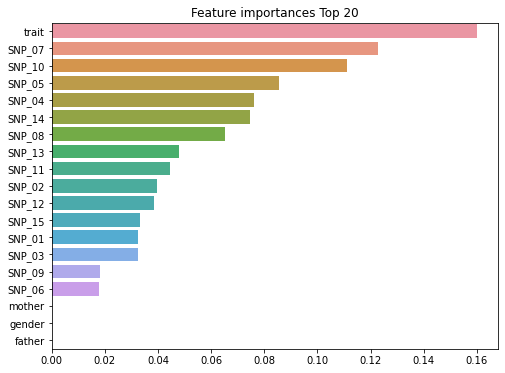

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [ ]:
train_x.corr()

,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
father,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mother,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trait,NaN,NaN,NaN,1.000000,0.655586,-0.608370,0.614024,-0.559170,0.565095,-0.550731,-0.820360,0.653951,-0.678855,0.663428,-0.648437,-0.671932,-0.619432,-0.727816,-0.503634
SNP_01,NaN,NaN,NaN,0.655586,1.000000,-0.352547,0.462172,-0.300665,0.408693,-0.380914,-0.525956,0.462378,-0.425966,0.499719,-0.376278,-0.476313,-0.405984,-0.537460,-0.316038
SNP_02,NaN,NaN,NaN,-0.608370,-0.352547,1.000000,-0.316231,0.420129,-0.221274,0.377807,0.493753,-0.351265,0.416581,-0.306429,0.399429,0.439501,0.292253,0.400794,0.324348
SNP_03,NaN,NaN,NaN,0.614024,0.462172,-0.316231,1.000000,-0.331834,0.305200,-0.387998,-0.537624,0.536249,-0.443257,0.499672,-0.341202,-0.340830,-0.348503,-0.522479,-0.262406
SNP_04,NaN,NaN,NaN,-0.559170,-0.300665,0.420129,-0.331834,1.000000,-0.223134,0.453711,0.455330,-0.293011,0.432299,-0.212199,0.388530,0.347525,0.275111,0.378727,0.189435
SNP_05,NaN,NaN,NaN,0.565095,0.408693,-0.221274,0.305200,-0.223134,1.000000,-0.367692,-0.577681,0.305523,-0.330828,0.474646,-0.251014,-0.365823,-0.508037,-0.449108,-0.298634
SNP_06,NaN,NaN,NaN,-0.550731,-0.380914,0.377807,-0.387998,0.453711,-0.367692,1.000000,0.419816,-0.441855,0.506569,-0.390117,0.396302,0.346101,0.412549,0.389656,0.296480


In [ ]:
clf = RandomForestClassifier(random_state=CFG.SEED)
clf.fit(train_x, train_y)

RandomForestClassifier(random_state=42)

In [ ]:
preds = clf.predict(test_x)
print('Done.')

Done.


### **4-3. XGBoost**

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

In [ ]:
xgb_clf = XGBClassifier()
get_model_train_eval(xgb_clf, ftr_train=X_train, ftr_test=X_tr_test, tgt_train=y_train, tgt_test=y_tr_test)

오차 행렬
[[11  0  0]
 [ 0 25  0]
 [ 0  1 16]]
정확도: 0.9811, 정밀도: 0.9872, 재현율: 0.9804, F1: 0.9834


In [ ]:
xgb_preds = xgb_clf.predict(test_x)
sub['class'] = class_le.inverse_transform(xgb_preds)

In [ ]:
sub.to_csv("/content/drive/MyDrive/ESAA/방학플젝1/sub_xgb.csv", index=False)

### **4-4. GBM**

### **4-5. Light GBM**

In [ ]:
from lightgbm import LGBMClassifier
import lightgbm as lgbm
lgbm_clf = LGBMClassifier()
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_tr_test, tgt_train=y_train, tgt_test=y_tr_test)

오차 행렬
[[11  0  0]
 [ 0 25  0]
 [ 0  1 16]]
정확도: 0.9811, 정밀도: 0.9872, 재현율: 0.9804, F1: 0.9834


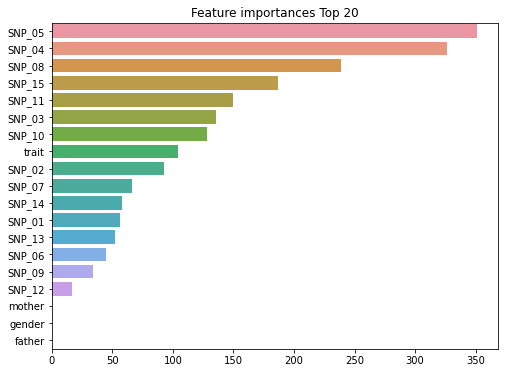

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = lgbm_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/ESAA/방학/DATA/sample_submission.csv')

In [ ]:
preds_lgbm_1 = lgbm_clf.predict(test_x)
submit['class'] = class_le.inverse_transform(preds_lgbm_1)

In [ ]:
submit.to_csv('/content/drive/MyDrive/ESAA/방학/DATA/submit_lgbm_1.csv', index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV 

In [ ]:
lgbm_clf1 = LGBMClassifier()
parameters = {'max_depth': [4,6,8,10],
              'learning_rate': [0.01,0.03,0.1,0.15],
              'n_estimators': [100,300,500]
}


lgbm_grid = GridSearchCV(lgbm_clf1,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose = True)
lgbm_grid.fit(X_train, y_train)

print(lgbm_grid.best_score_)
print(lgbm_grid.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
0.9568681318681318
{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500}


In [ ]:
lgbm_model = LGBMClassifier(learning_rate=0.03,max_depth=4,n_estimator=500)
#lgbm_model.fit(X_train, y_train, verbose=False)
get_model_train_eval(lgbm_model, ftr_train=X_train, ftr_test=X_tr_test, tgt_train=y_train, tgt_test=y_tr_test)

오차 행렬
[[11  0  0]
 [ 0 25  0]
 [ 0  3 14]]
정확도: 0.9434, 정밀도: 0.9643, 재현율: 0.9412, F1: 0.9489


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/ESAA/방학/DATA/sample_submission.csv')

In [ ]:
preds_lgbm_2 = lgbm_model.predict(test_x)
submit['class'] = class_le.inverse_transform(preds_lgbm_2)

In [ ]:
submit.to_csv('/content/drive/MyDrive/ESAA/방학/DATA/submit_lgbm_2.csv', index=False)

##**5. 제출**

In [ ]:
#Random Forest
submit = pd.read_csv('/content/drive/MyDrive/ESAA/방학/DATA/sample_submission.csv')

In [ ]:
submit['class'] = class_le.inverse_transform(preds)

In [ ]:
submit.to_csv('/content/drive/MyDrive/ESAA/방학/DATA/submit_rf_1.csv', index=False)